# Plot predictions and compare to satellite imagery

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import contextily as ctx

# For modelling
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from argparse import ArgumentParser
import yaml
from typing import Dict, Tuple, Union, Any
import pickle
import torch
from pathlib import Path
import os
import matplotlib.pyplot as plt
from pathlib import Path
import sys
base_dir = Path(os.path.dirname(os.path.realpath("__file__"))).parent
sys.path.insert(0, str(base_dir))
from models import MODELS


# For downloading EO data
import os
from pathlib import Path
import sys
base_dir = Path(os.path.dirname(os.path.realpath("__file__"))).parent.parent
sys.path.insert(0, os.path.join(base_dir, "eodal"))
import eodal
base_dir = Path(os.path.dirname(os.path.realpath("__file__"))).parent
sys.path.insert(0, str(base_dir))
from download_validation import *

### Check which val points have high errors

In [2]:
# Load config file

config_path = "../configs/config_NN copy.yaml"
with open(config_path, "r") as config_file:
      config = yaml.safe_load(config_file)



def prepare_data(config: dict) -> Union[Tuple[np.array, np.array, np.array, np.array], None]:
  ''' 
  Load data and prepare training and testing sets

  :param config: dictionary of configuration parameters
  :returns: X pd.DataFrame and y pd.Series for training and test sets 
  '''
  data_path = '../' + config['Data']['test_data_path']

  if isinstance(data_path, str):
    df = pd.read_pickle(data_path)
    X = df[config['Data']['train_cols']]
    y = df[config['Data']['target_col']]

    if config['Model']['name'] == 'RF':
      # Add derivatives
      derivatives = X.diff(axis=1)
      for col in X.columns[1:]:
          X[col + '_derivative'] = derivatives[col]
      # Add NDVI
      X['ndvi'] = (X['B08'] - X['B04'])/(X['B08'] + X['B04'])

    if config['Data']['normalize']:
      # Load scaler
      scaler_path = '../' + config['Model']['save_path'].split('.')[0] + '_scaler.pkl'
      with open(scaler_path, 'rb') as f:
        scaler = pickle.load(f)
      # Normalize
      X = scaler.transform(X)
      return X, y.values
      #X_train, X_test, y_train, y_test = train_test_split(X, y.values, test_size=config['Data']['test_size'], random_state=config['Seed'])
      #print('here')
      #return X_test, y_test
    else:
      return X, y.values

  elif isinstance(data_path, list):
    # Assuming all files in the list are pickled DataFrames
    dfs = [pd.read_pickle(path) for path in data_path]
    concatenated_df = pd.concat(dfs, axis=0, ignore_index=True)
    X = concatenated_df[config['Data']['train_cols']] #  concatenated_df[config['Data']['train_cols']]
    y = concatenated_df[config['Data']['target_col']] #  concatenated_df[config['Data']['target_col']]

    if config['Model']['name'] == 'RF':
      # Add derivatives
      derivatives = X.diff(axis=1)
      for col in X.columns[1:]:
          X[col + '_derivative'] = derivatives[col]
      # Add NDVI
      X['ndvi'] = (X['B08'] - X['B04'])/(X['B08'] + X['B04'])
      
    if config['Data']['normalize']:
      # Load scaler
      scaler_path = '../' + config['Model']['save_path'].split('.')[0] + '_scaler.pkl'
      with open(scaler_path, 'rb') as f:
        scaler = pickle.load(f)
      # Normalize
      X = scaler.transform(X)
      return X, y.values
    else:
      return X, y.values

  else:
      return None

X_test, y_test = prepare_data(config)

# Move data to CUDA if GPUs requested and available
device = torch.device('cuda' if config['Model'].get('gpu') and torch.cuda.is_available() else 'cpu')
if device == torch.device('cuda'):
    X_test, y_test = (
        torch.FloatTensor(X_test).to(device),
        torch.FloatTensor(y_test).view(-1, 1).to(device)
    )



#############################################
# MODEL
save_model = config['Model'].pop('save')
model_name = config['Model']['name']
model_filename = '../' + config['Model'].pop('save_path') 
with open(model_filename, 'rb') as f:
  model = pickle.load(f)

# Move model to CUDA if GPUs are available
if device == torch.device('cuda'):
    model.to(device)

#############################################
# TEST
if model_name == 'GPR': # Active learning
  y_pred, y_std = model.predict(X_test, return_std=True)
  print('Mean test std', y_std.mean()) 
  model.test_scores(y_test=y_test, y_pred=y_pred, dataset='Val')
else: 
  y_pred = model.predict(X_test=X_test)
  model.test_scores(y_test=y_test, y_pred=y_pred, dataset='Val')



# Move y_pred to CPU if it's on CUDA device
if isinstance(y_pred, torch.Tensor) and y_pred.device.type == 'cuda':
    y_pred = y_pred.cpu().detach().numpy()
if isinstance(y_test, torch.Tensor) and y_test.device.type == 'cuda':
    y_test = y_test.cpu().detach().numpy()
          
slope, intercept = np.polyfit(y_test.flatten(), y_pred.flatten(), 1)

Val RMSE: 1.3341929912567139
Val MAE: 1.0893765687942505
Val R2: -0.11463060098192734
Regression slope: 0.8469660672222643
Regression intercept: 0.5426409642874394
Val rmselow: 0.9028106331825256
Val fabio: 0.24628890690647354


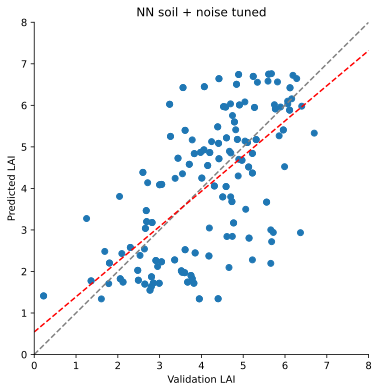

In [3]:
# Plot ypred vs ytest

fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(y_test, y_pred)
ax.set_xlabel('Validation LAI')
ax.set_ylabel('Predicted LAI')
#ax.set_title(f'Pred vs True. {model_filename.split(".pkl")[0].split("/")[-1]} - {config["Data"]["test_data_path"].split("/")[-1].split(".pkl")[0]}')
ax.set_title(f'NN soil + noise tuned')
ax.set_xlim((0,8))
ax.set_ylim((0,8))

# Plot y=x line
ax.plot([0, 8], [0, 8], color='gray', linestyle='--')

# Plot regression line
xseq = np.linspace(0, 8, num=100)
ax.plot(xseq, intercept + slope * xseq, color="r", linestyle='--')

# Hide the top and right spine
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

#plt.savefig(f'trained_models/pred_vs_true_{model_filename.split(".pkl")[0].split("/")[-1].split(".pkl")[0]}_{config["Data"]["test_data_path"].split("/")[-1].split(".pkl")[0]}.png')

In [4]:
# Find high residuals

absolute_diff = np.abs(y_test - y_pred)
indices = np.where(absolute_diff > 1.5)
y_test_values = y_test[indices]

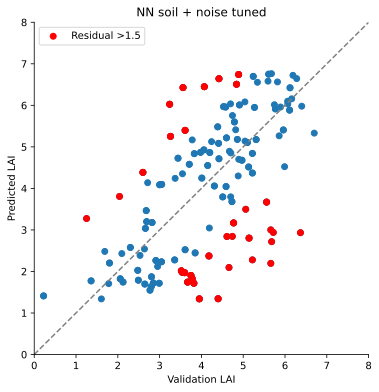

In [5]:
# Plot ypred vs ytest

fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(y_test, y_pred)
ax.scatter(y_test[indices], y_pred[indices], color='red', label='Residual >1.5')
ax.set_xlabel('Validation LAI')
ax.set_ylabel('Predicted LAI')
#ax.set_title(f'Pred vs True. {model_filename.split(".pkl")[0].split("/")[-1]} - {config["Data"]["test_data_path"].split("/")[-1].split(".pkl")[0]}')
ax.set_title(f'NN soil + noise tuned')
ax.set_xlim((0,8))
ax.set_ylim((0,8))
ax.legend()

# Plot y=x line
ax.plot([0, 8], [0, 8], color='gray', linestyle='--')


# Hide the top and right spine
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

#plt.savefig(f'trained_models/pred_vs_true_{model_filename.split(".pkl")[0].split("/")[-1].split(".pkl")[0]}_{config["Data"]["test_data_path"].split("/")[-1].split(".pkl")[0]}.png')

### Choose date and location to analyse

In [6]:
val_path = '../../results/validation_data_extended_lai.pkl'
val_gdf = pd.read_pickle(val_path)

In [7]:
gdf_highres = val_gdf.reset_index(drop=True, inplace=False).iloc[indices[0]]
# Analyse location and date: Strickhof, 2022-06-17
gdf = gdf_highres[(gdf_highres.location == 'Strickhof') & (gdf_highres['date'].str.contains('2022-06-17'))]
idx = gdf.index 

In [11]:
# Low LAI: Strickhof 2023-03-22
gdf_highres = val_gdf.reset_index(drop=True, inplace=False)
gdf = gdf_highres[(gdf_highres.location == 'Strickhof') & (gdf_highres['date'].str.contains('2023-03-22')) & (gdf_highres.lai < 3)]
idx = gdf.index 

In [12]:
gdf

,B02,B03,B04,B05,B06,B07,B08,B8A,B11,B12,geometry,date,lai,location,green_canopy_cover
173,0.0305,0.0608,0.0289,0.1018,0.4067,0.5145,0.5360,0.5219,0.1681,0.0791,POINT (8.68078 47.44167),2023-03-22 14:24:00,1.252163,Strickhof,76.789297
185,0.0308,0.0568,0.0360,0.0919,0.2997,0.3679,0.3732,0.3794,0.1660,0.0867,POINT (8.68545 47.44146),2023-03-22 15:45:00,1.781925,Strickhof,57.365562


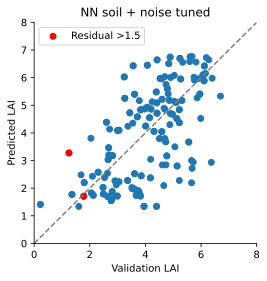

In [13]:
# Plot ypred vs ytest

fig, ax = plt.subplots(figsize=(4,4))
ax.scatter(y_test, y_pred)
ax.scatter(y_test[idx], y_pred[idx], color='red', label='Residual >1.5')
ax.set_xlabel('Validation LAI')
ax.set_ylabel('Predicted LAI')
ax.set_title(f'NN soil + noise tuned')
ax.set_xlim((0,8))
ax.set_ylim((0,8))
ax.legend()

# Plot y=x line
ax.plot([0, 8], [0, 8], color='gray', linestyle='--')


# Hide the top and right spine
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

### Download S2 data and plot it vs prediction LAI
- For strickhof farm on 2022-06-17
- For Arenenberg farm on 2022-06-15
- Low LAI: Strickhof 2023-03-22

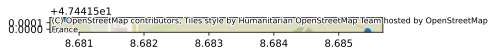

In [14]:
fig, ax = plt.subplots(figsize=(6,6))
gdf.plot(ax=ax)
ctx.add_basemap(ax, crs=gdf.crs)

In [16]:
insitu_path = '../../data/in-situ/in-situ_glai_2023.gpkg'
insitu_gdf = gpd.read_file(insitu_path)

# For low LAI
bbox = gdf.total_bounds
polygon_geom = box(bbox[0], bbox[1], bbox[2], bbox[3])
polygon_gdf = gpd.GeoDataFrame(geometry=[polygon_geom], crs=gdf.crs)

s2_data = extract_s2_data(
    aoi=polygon_gdf, #insitu_gdf[insitu_gdf.location=='Strickhof'].dissolve(),
    time_start=pd.to_datetime('2023-03-22'), # - timedelta(days=1), 
    time_end=pd.to_datetime('2023-03-22') + timedelta(days=1)
)

2024-05-03 16:37:10,768 eodal        INFO     Starting extraction of sentinel2 scenes
2024-05-03 16:37:13,580 eodal        INFO     Finished extraction of sentinel2 scenes


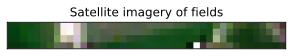

In [17]:
scoll = s2_data.data
f, ax = plt.subplots(figsize=(5,5))
i = 0
for scene_id, scene in scoll:
    if i == 0:
      scene.plot_multiple_bands(
          band_selection=['red', 'green' ,'blue'],
          ax=ax
      )
      #ax.set_title(scene_id)
      # Remove x and y ticks and labels
      plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
      ax.set_xlabel('')
      ax.set_ylabel('')
      ax.set_title('Satellite imagery of fields')

      scene_df = scene.to_dataframe()
    i += 1

# Get x and y tick positions and labels
x_tick_positions = ax.get_xticks()
x_tick_labels = ax.get_xticklabels()
y_tick_positions = ax.get_yticks()
y_tick_labels = ax.get_yticklabels()

2024-05-03 16:37:46,463 eodal        INFO     Starting extraction of sentinel2 scenes
2024-05-03 16:37:46,752 eodal        INFO     Finished extraction of sentinel2 scenes


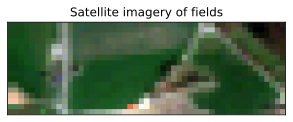

In [19]:
insitu_path = '../../data/in-situ/in-situ_glai_2023.gpkg'
insitu_gdf = gpd.read_file(insitu_path)

bbox = insitu_gdf[insitu_gdf.location == 'Strickhof'].total_bounds
polygon_geom = box(bbox[0], bbox[1], bbox[2], bbox[3])
polygon_gdf = gpd.GeoDataFrame(geometry=[polygon_geom], crs=insitu_gdf.crs)

s2_data = extract_s2_data(
    aoi=polygon_gdf,
    time_start=pd.to_datetime('2023-03-22'), # - timedelta(days=1), 
    time_end=pd.to_datetime('2023-03-22') + timedelta(days=1)
)


scoll = s2_data.data
f, ax = plt.subplots(figsize=(5,5))
i = 0
for scene_id, scene in scoll:
    if i == 0:
      scene.plot_multiple_bands(
          band_selection=['red', 'green' ,'blue'],
          ax=ax
      )
      #ax.set_title(scene_id)
      # Remove x and y ticks and labels
      plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
      ax.set_xlabel('')
      ax.set_ylabel('')
      ax.set_title('Satellite imagery of fields')

    i += 1

# Get x and y tick positions and labels
x_tick_positions = ax.get_xticks()
x_tick_labels = ax.get_xticklabels()
y_tick_positions = ax.get_yticks()
y_tick_labels = ax.get_yticklabels()

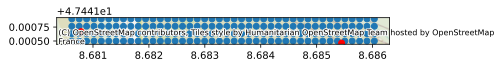

In [20]:
fig, ax = plt.subplots(figsize=(6,6))
scene_df.plot(ax=ax)
gdf.plot(ax=ax, color='red')
ctx.add_basemap(ax, crs=scene_df.crs)

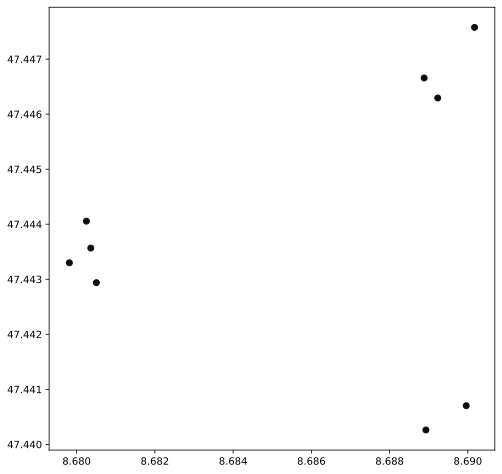

In [29]:
fig, ax = plt.subplots(figsize=(8, 8))

# Plot each pixel with its RGB color
for idx, row in gdf.iterrows():
    # Extract RGB values
    red = row['B04'] 
    green = row['B03'] 
    blue = row['B02'] 
    # Plot pixel as a point with the corresponding RGB color
    ax.scatter(row.geometry.x, row.geometry.y, color=(red, green, blue))